## The data was copied from previous project
check that the size of the copied data (`/home/vit/Projects/flexibility-analysis/data/features/coevolution/cryptobench-dataset`) matches the data from this project

In [ ]:
import os 
import numpy as np

for filename in os.listdir('/home/vit/Projects/flexibility-analysis/data/features/coevolution/cryptobench-dataset'):
    coevolution = np.load('/home/vit/Projects/flexibility-analysis/data/features/coevolution/cryptobench-dataset/' + filename, allow_pickle=True)
    fluctuation_shape = np.load('/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset/fluctuation/' + filename).shape[0]
    max_index = - np.inf
    for i in coevolution:
        if i[0][1] > max_index:
            max_index = i[0][1]
    assert max_index == fluctuation_shape - 1
    print(filename, max_index, fluctuation_shape - 1)


In [22]:
import statistics
import os
import numpy as np


def compute_basic_stats(coevolution_path, indices_path, fluctuation_path):
    both_binding = 0
    one_binding = 0
    none_binding = 0

    both_binding_values = []
    one_binding_values = []
    none_binding_values = []

    total_both_binding = 0
    total_one_binding = 0
    total_none_binding = 0


    for filename in os.listdir(coevolution_path):
        id = filename.split('.')[0]
        binding_indices = np.load(f'{indices_path}/{id}.npy')
        coevolution_pairs = np.load(f'{coevolution_path}/{id}.npy', allow_pickle=True)
        sequence_len = len(np.load(f'{fluctuation_path}/{id}.npy'))
        # take the most relevant coevolution pairs: (N / 5 coevolution pairs, where N is the sequence length)   
        maximum = coevolution_pairs[0][1]
        minimum = coevolution_pairs[int(sequence_len / 5) - 1][1]
        for i in coevolution_pairs[:(int(sequence_len / 5))]:
            value = (i[1] + abs(minimum)) / (maximum + abs(minimum)) 
            if i[0][0] in binding_indices and i[0][1] in binding_indices:
                both_binding += 1
                both_binding_values.append(value)
            elif i[0][0] in binding_indices or i[0][1] in binding_indices:
                one_binding += 1
                one_binding_values.append(value)
            else:
                none_binding += 1
                none_binding_values.append(value)

        binding_len = len(binding_indices)
        nonbinding_len = (sequence_len - len(binding_indices))
        total_both_binding += binding_len**2 / 2
        total_one_binding += nonbinding_len*binding_len / 2
        total_none_binding += nonbinding_len**2 / 2

    print(f'both binding = {both_binding} out of {round(total_both_binding)}: {(both_binding / total_both_binding * 100):.2f}%, median value: {statistics.median(both_binding_values):.3f}')
    print(f'one binding = {one_binding} out of {round(total_one_binding)}: {(one_binding / total_one_binding * 100):.2f}%, median value: {statistics.median(one_binding_values):.3f}')
    print(f'none binding = {none_binding} out of {round(total_none_binding)}: {(none_binding / total_none_binding * 100):.2f}%, median value: {statistics.median(none_binding_values):.3f}')



In [23]:
print("Coevolution stats for Cryptobench dataset:")
coevolution_path = '/home/vit/Projects/flexibility-analysis/data/features/coevolution/cryptobench-dataset'
fluctuation_path = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset/fluctuation'
indices_path = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset/indices'
compute_basic_stats(coevolution_path, indices_path, fluctuation_path)

Coevolution stats for Cryptobench dataset:
both binding = 1644 out of 155564: 1.06%, median value: 0.789
one binding = 4969 out of 1822782: 0.27%, median value: 0.791
none binding = 37001 out of 36004244: 0.10%, median value: 0.789


In [24]:
print("Coevolution stats for RIGID dataset:")
coevolution_path = '/home/vit/Projects/flexibility-analysis/data/features/coevolution/rigid-dataset'
fluctuation_path = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset/fluctuation'
indices_path = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset/indices'
compute_basic_stats(coevolution_path, indices_path, fluctuation_path)

Coevolution stats for RIGID dataset:
both binding = 485 out of 37830: 1.28%, median value: 0.795
one binding = 2135 out of 937449: 0.23%, median value: 0.788
none binding = 30960 out of 38444744: 0.08%, median value: 0.788


In [25]:
import biotite.structure.io.pdbx as pdbx
from biotite.sequence import ProteinSequence
import biotite.structure as struc
import matplotlib.pyplot as plt

CIF_FILES_PATH = '/home/vit/Projects/deeplife-project/data/cif_files'

def compute_basic_stats(coevolution_path, indices_path, fluctuation_path):
    both_cbs_aa_pairs = {}
    one_cbs_aa_pairs = {}
    none_cbs_aa_pairs = {}
    
    def add_to_aa_pairs(aa1, aa2, dict):
        if f'{aa1}-{aa2}' not in dict and f'{aa2}-{aa1}' not in dict:
            if aa1 > aa2:
                dict[f'{aa1}-{aa2}'] = 1
            else:
                dict[f'{aa2}-{aa1}'] = 1
    
        elif f'{aa1}-{aa2}' in dict:
            dict[f'{aa1}-{aa2}'] += 1
        elif f'{aa2}-{aa1}' in dict:
            dict[f'{aa2}-{aa1}'] += 1
    
    
    for filename in os.listdir(coevolution_path):
        id = filename.split('.')[0]
        binding_indices = np.load(f'{indices_path}/{id}.npy')
        coevolution_pairs = np.load(f'{coevolution_path}/{id}.npy', allow_pickle=True)
        sequence_len = len(np.load(f'{fluctuation_path}/{id}.npy'))
    
        mmcif_filename = f'{id[:4]}.cif'
        mmcif_file = pdbx.CIFFile.read(f'{CIF_FILES_PATH}/{mmcif_filename}')
    
        # load file to biotite object
        whole_structure = pdbx.get_structure(mmcif_file, model=1, include_bonds=True)
        protein = whole_structure[struc.filter_amino_acids(whole_structure)]
    
        # some errors with MSE residue
        c_alphas = protein[(protein.atom_name == "CA") 
                           & (protein.element == "C") 
                           & (protein.chain_id == id[4:]) 
                           & (
                                 (protein.res_name == 'ALA')
                               | (protein.res_name == 'ARG')
                               | (protein.res_name == 'ASN')
                               | (protein.res_name == 'ASP')
                               | (protein.res_name == 'CYS')
                               | (protein.res_name == 'GLN')
                               | (protein.res_name == 'GLU')
                               | (protein.res_name == 'GLY')
                               | (protein.res_name == 'HIS')
                               | (protein.res_name == 'ILE')
                               | (protein.res_name == 'LEU')
                               | (protein.res_name == 'LYS')
                               | (protein.res_name == 'MET')
                               | (protein.res_name == 'PHE')
                               | (protein.res_name == 'PRO')
                               | (protein.res_name == 'SER')
                               | (protein.res_name == 'THR')
                               | (protein.res_name == 'TRP')
                               | (protein.res_name == 'TYR')
                               | (protein.res_name == 'VAL'))]
        
        sequence = ''.join([ProteinSequence.convert_letter_3to1(residue.res_name) for residue in c_alphas])
        assert sequence_len == len(sequence)
    
        for i in coevolution_pairs[:(int(sequence_len / 2))]:
            aa1 = sequence[i[0][0]]
            aa2 = sequence[i[0][1]]
    
            if i[0][0] in binding_indices and i[0][1] in binding_indices:
                add_to_aa_pairs(aa1, aa2, both_cbs_aa_pairs)
            elif i[0][0] in binding_indices or i[0][1] in binding_indices:
                add_to_aa_pairs(aa1, aa2, one_cbs_aa_pairs)
            else:
                add_to_aa_pairs(aa1, aa2, none_cbs_aa_pairs)
    
    def normalize_pairs(pairs):
        values = [v for k, v in pairs]
        min_val = min(values)
        max_val = max(values)

        normalized_pairs = [(k, (v - min_val) / (max_val - min_val)) for k, v in pairs]
        return normalized_pairs


    sorted_none_cbs_aa_pairs = normalize_pairs([(k, v) for k, v in sorted(none_cbs_aa_pairs.items(), key=lambda kv: (kv[1]), reverse=True)])
    sorted_one_cbs_aa_pairs = normalize_pairs([(k, v) for k, v in sorted(one_cbs_aa_pairs.items(), key=lambda kv: (kv[1]), reverse=True)])
    sorted_both_cbs_aa_pairs = normalize_pairs([(k, v) for k, v in sorted(both_cbs_aa_pairs.items(), key=lambda kv: (kv[1]), reverse=True)])

    return sorted_none_cbs_aa_pairs, sorted_one_cbs_aa_pairs, sorted_both_cbs_aa_pairs

def create_distance_matrix(pairs):
    # Extract unique amino acids
    amino_acids = set()
    for k, _ in pairs:
        x, y = k.split('-')
        amino_acids.add(x)
        amino_acids.add(y)
    amino_acids = sorted(amino_acids)
    
    # Create a dictionary to map letters to indices
    amino_acids_to_index = {amino_acid: i for i, amino_acid in enumerate(amino_acids)}
    
    # Initialize the distance matrix
    size = len(amino_acids)
    matrix = np.zeros((size, size))
    
    # Fill the matrix with normalized values
    for k, v in pairs:
        x, y = k.split('-')
        i, j = amino_acids_to_index[x], amino_acids_to_index[y]
        matrix[i, j] = v
        matrix[j, i] = v  # Assuming the matrix is symmetric
    
    return matrix, amino_acids

def plot_distance_matrix(matrix, labels, title='Coevolution'):
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='CMRmap_r')
    fig.colorbar(cax)
    
    # Set axis labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    # Set title
    ax.set_title(title)

    # Rotate the tick labels
    plt.xticks(rotation=90)

    plt.show()

def plot(aa_pairs, title):
    matrix, labels = create_distance_matrix(aa_pairs)
    plot_distance_matrix(matrix, labels, title)


Coevolution amino-acid type heatmaps for Cryptobench dataset:


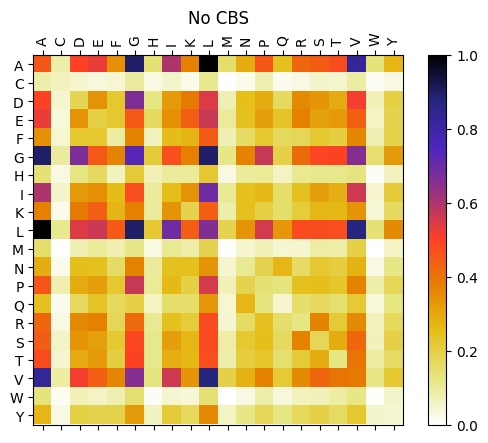

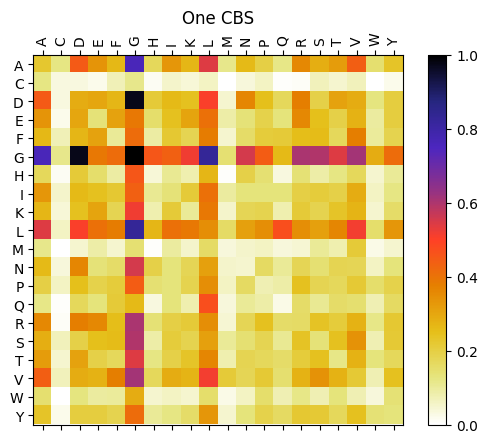

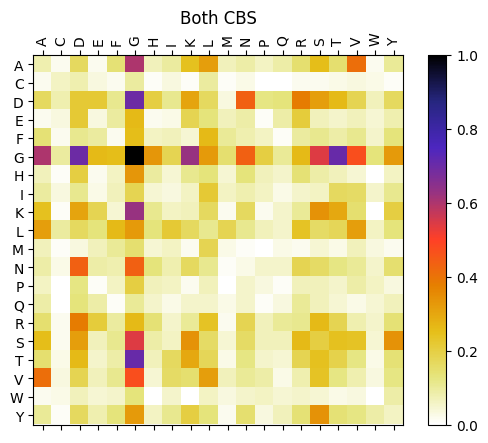

In [28]:
print("Coevolution amino-acid type heatmaps for Cryptobench dataset:")
coevolution_path = '/home/vit/Projects/flexibility-analysis/data/features/coevolution/cryptobench-dataset'
fluctuation_path = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset/fluctuation'
indices_path = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/cryptobench-dataset/indices'

sorted_none_cbs_aa_pairs_cryptic, sorted_one_cbs_aa_pairs_cryptic, sorted_both_cbs_aa_pairs_cryptic = compute_basic_stats(coevolution_path, indices_path, fluctuation_path)
plot(sorted_none_cbs_aa_pairs_cryptic, 'No CBS')
plot(sorted_one_cbs_aa_pairs_cryptic, 'One CBS')
plot(sorted_both_cbs_aa_pairs_cryptic, 'Both CBS')


Coevolution amino-acid type heatmaps for RIGID dataset:


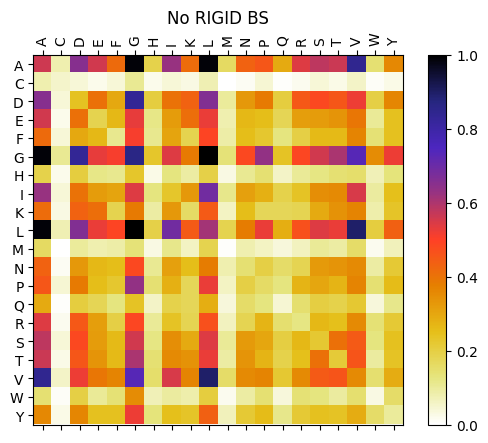

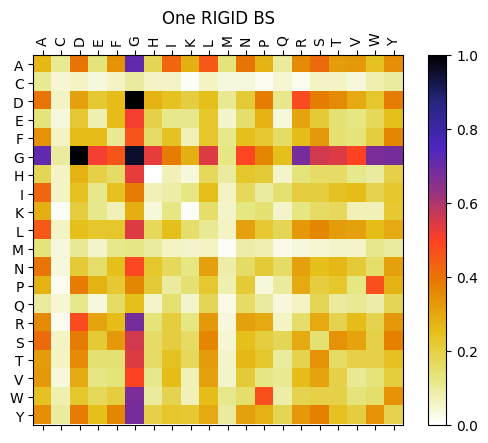

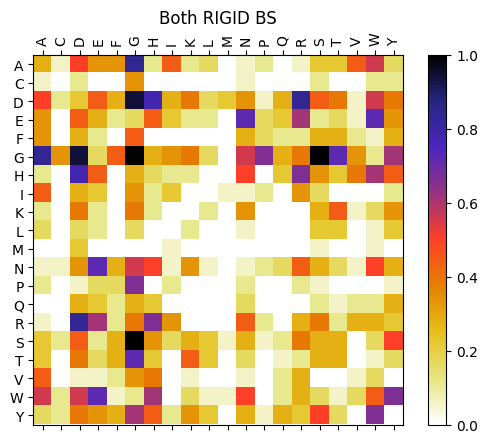

In [34]:
print("Coevolution amino-acid type heatmaps for RIGID dataset:")
coevolution_path = '/home/vit/Projects/flexibility-analysis/data/features/coevolution/rigid-dataset'
fluctuation_path = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset/fluctuation'
indices_path = '/home/vit/Projects/flexibility-analysis/data/features/fluctuation/rigid-dataset/indices'

sorted_none_cbs_aa_pairs_rigid, sorted_one_cbs_aa_pairs_rigid, sorted_both_cbs_aa_pairs_rigid = compute_basic_stats(coevolution_path, indices_path, fluctuation_path)
plot(sorted_none_cbs_aa_pairs_rigid, 'No RIGID BS')
plot(sorted_one_cbs_aa_pairs_rigid, 'One RIGID BS')
plot(sorted_both_cbs_aa_pairs_rigid, 'Both RIGID BS')


In [30]:
def plot_difference(aa_pairs1, aa_pairs2, title):
    matrix1, labels = create_distance_matrix(aa_pairs1)
    matrix2, _ = create_distance_matrix(aa_pairs2)
    plot_distance_matrix(matrix1 - matrix2, labels, title)


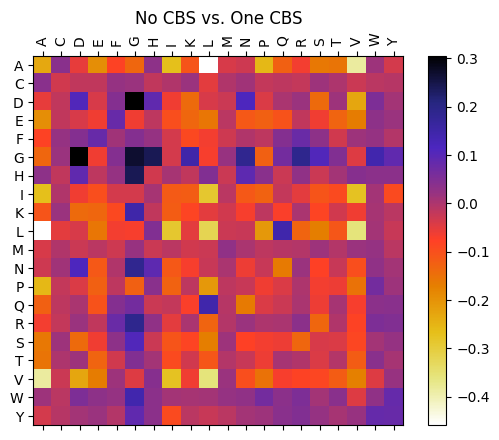

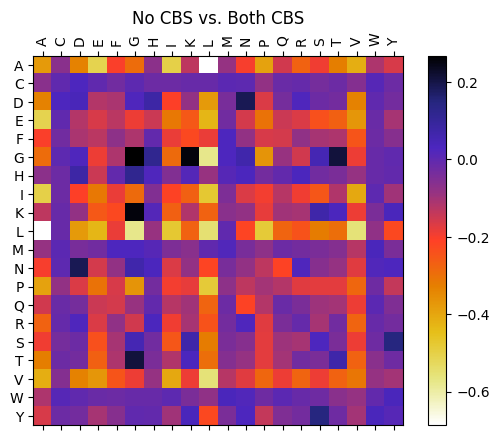

In [31]:
plot_difference(sorted_one_cbs_aa_pairs_cryptic, sorted_none_cbs_aa_pairs_cryptic, 'No CBS vs. One CBS')
plot_difference(sorted_both_cbs_aa_pairs_cryptic, sorted_none_cbs_aa_pairs_cryptic, 'No CBS vs. Both CBS')

## The graph above has the following interpretation:
White means that the pair is enriched in non-biding coevolution pairs, black means that the pair is enriched in binding coevolution pairs

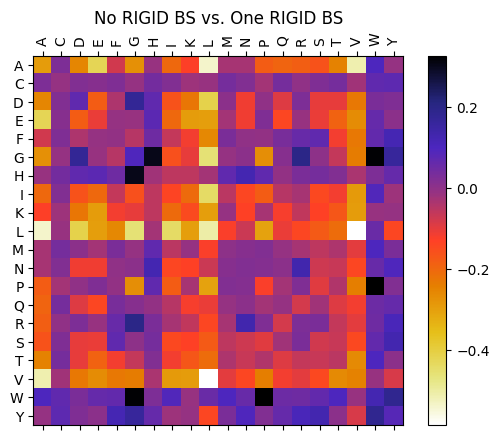

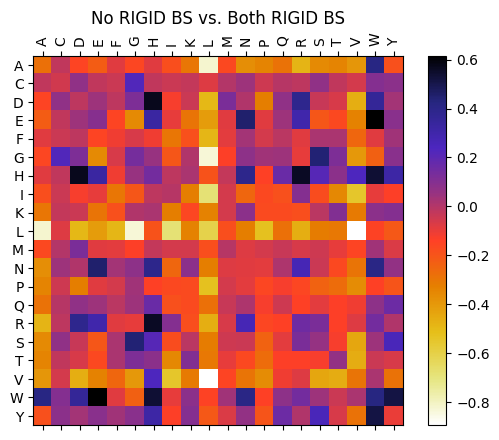

In [35]:
plot_difference(sorted_one_cbs_aa_pairs_rigid, sorted_none_cbs_aa_pairs_rigid, 'No RIGID BS vs. One RIGID BS')
plot_difference(sorted_both_cbs_aa_pairs_rigid, sorted_none_cbs_aa_pairs_rigid, 'No RIGID BS vs. Both RIGID BS')

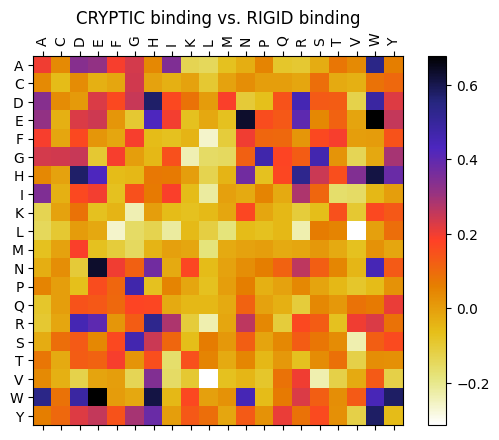

In [33]:
plot_difference(sorted_both_cbs_aa_pairs_rigid, sorted_both_cbs_aa_pairs_cryptic, 'CRYPTIC binding vs. RIGID binding')

## The graph above has the following interpretation:
White means that the pair is enriched in CryptoBench, black means that the pair is enriched in RIGID